# Multi-Layer Perceptrons and Convolutional Neural Networks

In this notebook, we'll implement both MLPs and CNNs using PyTorch and explore their applications.
MLPs are versatile feedforward neural networks used for classification and regression.
CNNs are also neural networks specialized for image classification and object recognition tasks.

## Imported packages/libraries

In [6]:
# Importing required libraries for data manipulation and visualisation, models and metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import time
import random

# Downloading EMNIST Dataset from Kaggle

To download the EMNIST dataset from Kaggle, we used Kaggle's command-line interface directly in Google Colab. Since PyTorch's functionality didn't work for downloading the dataset, we resorted to using Kaggle.

In [3]:
# # Code to download EMNIST dataset from kaggle

# # Upload kaggle.json
# from google.colab import files
# files.upload()

# #Move json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# # Download dataset from kaggle
!kaggle datasets download -d crawford/emnist



100% 1.24G/1.24G [00:08<00:00, 231MB/s]
100% 1.24G/1.24G [00:08<00:00, 159MB/s]


## Extracting only Balanced dataset

The below code extracts only the files related to the "Balanced" split from the downloaded EMNIST dataset. It creates a new directory named emnist_balanced and extracts the relevant files into it

In [7]:
import zipfile
import os

# Path to the downloaded zip file
zip_file_path = 'emnist.zip'

# Directory to extract the files
extract_dir = 'emnist_balanced'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)

# Extract only the files related to the "Balanced" split
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    for file_info in zip_ref.infolist():
        if 'balanced' in file_info.filename:
            zip_ref.extract(file_info, extract_dir)

# List the extracted files
extracted_files = os.listdir(extract_dir)
print("Extracted files:", extracted_files)



Extracted files: ['emnist-balanced-test.csv', 'emnist-balanced-mapping.txt', 'emnist-balanced-train.csv', 'emnist_source_files']


## Defining class to load dataset from CSV


The dataset class implements three essential methods required by PyTorch's DataLoader:

1. Initialisation of the dataset by loading the EMNIST dataset from a CSV file for data transformations.

2. Length method returns the total number of samples in the dataset.

3. Get item method retrieves a sample from the dataset at the specified index and returns both the image data and its corresponding label.



In [8]:
class EMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None).values
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx, 1:].reshape(28, 28).astype(np.uint8)
        label = int(self.data[idx, 0])
        if self.transform:
            image = self.transform(image)
        return image, label


## Preparing data for training and evaluation

We define a transformation pipeline `transform` using PyTorch's `transforms.Compose` utility. This pipeline includes three transformations:
1. `ToPILImage()`: Converts tensors to PIL images.
2. `Resize((28, 28))`: Resizes images to a 28x28 resolution.
3. `ToTensor()`: Converts PIL images back to tensors.

Next, we load the test data using our custom `EMNISTDataset` class instantiated with the specified transformation pipeline.

We also load the full training data and split it into training and validation sets using the `train_test_split` function from `sklearn.model_selection`. The training set will be used for training our model, while the validation set will be used for model evaluation and tuning hyperparameters.


In [10]:
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensors to PIL images
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.ToTensor()  # Convert PIL images to tensors
])

# Load the test data
test_data = EMNISTDataset('emnist_balanced/emnist-balanced-test.csv', transform=transform)

# Load the training data
full_train_data = EMNISTDataset('emnist_balanced/emnist-balanced-train.csv', transform=transform)

# Split the full training data into training and validation sets
train_data, val_data = train_test_split(full_train_data, test_size=0.2, random_state=42)

# Define the batch size
batch_size = 256

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


## Printing the number of dataset

In [11]:
# Get the number of samples in the training dataset
num_train_samples = len(train_loader.dataset)

# Get the number of samples in the testing dataset
num_test_samples = len(test_loader.dataset)

# Get the number of samples in the testing dataset
num_val_samples = len(val_loader.dataset)

print("Number of samples in the training dataset:", num_train_samples)
print("Number of samples in the testing dataset:", num_test_samples)
print("Number of samples in the validation dataset:", num_val_samples)

Number of samples in the training dataset: 90240
Number of samples in the testing dataset: 18800
Number of samples in the validation dataset: 22560


## Check availability of CUDA
We configure the device for computation based on the availability of CUDA. CUDA enables dramatic acceleration of computing tasks using the GPU (Graphics Processing Unit) providing significant speedup for training and inference tasks compared to CPU-only execution..


In [ ]:
# Device configuration
# Set the device based on availability of CUDA
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True


## Define function to display images

We define a function `show_images(dataset, num_samples=4)` to display images from the dataset. The function takes two arguments:
- `dataset`: The dataset from which images will be displayed.
- `num_samples` (optional): The number of samples to display. By default, it displays 4 samples.



Train Dataset:


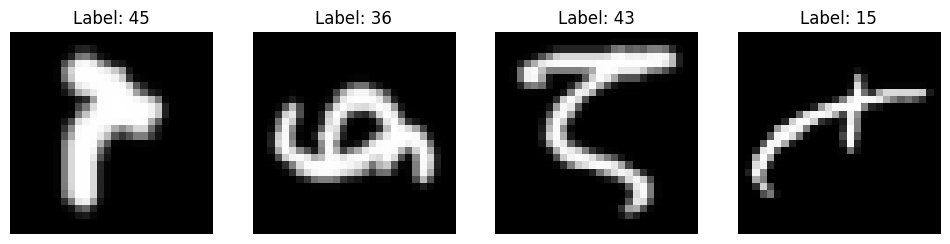

Test Dataset:


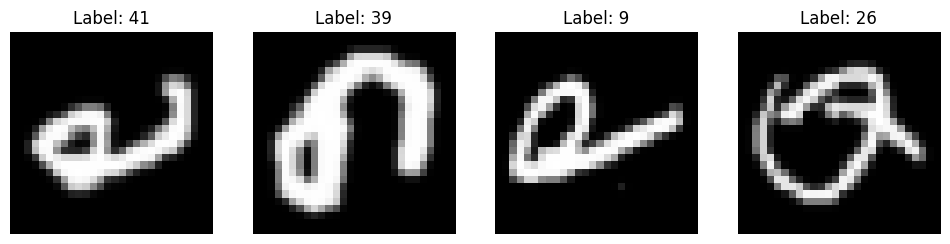

In [ ]:
# Define a function to display images
def show_images(dataset, num_samples=4):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))

    for i in range(num_samples):
        image, label = dataset[i]
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()

# Show images from the train dataset
print("Train Dataset:")
show_images(full_train_data)

# Show images from the test dataset
print("Test Dataset:")
show_images(test_data)


## Hyper-parameters of the neural networks

Hyper-parameters refer to the settings and parameters that define the architecture and behavior of the model. Initially we have set the parameters manually to train the models. The parameters below are later tuned via random search to improve the model's performance.

In [ ]:
# Define the input size as the total number of pixels in the input image (28x28=784)
input_size = 28*28

# Set the number of nodes in the hidden layer
hidden_size = 256

# Number of output classes in the dataset
num_classes = 47

# Number of input samples used in each iteration for training
batch_size = 256

# Set the learning rate for the optimizer
lr = 0.01

# Set the number of epochs for training
epochs = 25

# Set the activation function for the hidden layer nodes
activation = 'relu'

# Set the optimizer to be used during training
optimizer = optim.Adam

# Flag to enable batch normalization
batch_norm = True

# Regularization parameter for the model
regularization_lambda = 0.001

# Dropout rate for regularization during training
dropout = 0.2

# Type of regularization used in the model
regularization = "l2"

## Define the MLP Model

We define a multilayer perceptron (MLP) model using PyTorch's `nn.Module` class. The model consists of fully connected layers (fc1, fc2, fc3, fc4) with batch normalization and activation functions.

- The `__init__` method initializes the model by defining the fully connected layers and storing hyperparameters such as activation function, batch normalization, dropout probability, and regularization.
- The `forward` method defines the forward pass of the model, where the input tensor is flattened and passed through the fully connected layers with batch normalization, activation functions, and dropout regularization.


In [ ]:
# Initialize the model, loss function, and optimizer
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, activation, batch_norm, dropout, regularization):
        super(MLP, self).__init__()

        # Define the fully connected layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, num_classes)

        # Store the hyperparameters
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.regularization = regularization

        # Add batch normalization if enabled
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(hidden_size)
            self.bn2 = nn.BatchNorm1d(hidden_size)
            self.bn3 = nn.BatchNorm1d(hidden_size)

        # Add regularization if enabled
        if self.regularization:
            self.l1 = nn.L1Loss()
            self.l2 = nn.MSELoss()

    def forward(self, x):
    # Flatten the input tensor
        x = x.view(x.size(0), -1)
        out = self.fc1(x)
        if self.batch_norm:
            out = self.bn1(out)
        if self.activation == 'relu':
            out = F.relu(out)
        elif self.activation == 'sigmoid':
            out = F.sigmoid(out)
        elif self.activation == 'tanh':
            out = F.tanh(out)
        if self.dropout:
            out = F.dropout(out, p=self.dropout)
        out = self.fc2(out)
        if self.batch_norm:
            out = self.bn2(out)
        if self.activation == 'relu':
            out = F.relu(out)
        elif self.activation == 'sigmoid':
            out = F.sigmoid(out)
        elif self.activation == 'tanh':
            out = F.tanh(out)
        if self.dropout:
            out = F.dropout(out, p=self.dropout)
        out = self.fc3(out)
        if self.batch_norm:
            out = self.bn3(out)
        if self.activation == 'relu':
            out = F.relu(out)
        elif self.activation == 'sigmoid':
            out = F.sigmoid(out)
        elif self.activation == 'tanh':
            out = F.tanh(out)
        if self.dropout:
            out = F.dropout(out, p=self.dropout)
        out = self.fc4(out)
        return out

## MLP Model Training

- The model is initialized with the specified input size, hidden layer size, number of output classes, activation function, batch normalization, dropout probability, and regularization.
- We use the cross-entropy loss function and the Adam optimizer for training the model.
- Learning rate scheduling is performed using the ReduceLROnPlateau scheduler, which reduces the learning rate when the validation loss plateaus.
- During each epoch of training, we compute the training accuracy, update the model parameters using backpropagation, and print the loss and accuracy.
- The training process is repeated for the specified number of epochs, and the training time is recorded.
- Finally, we store the training results (iteration, accuracy, and loss) in a list and print the training time.


In [ ]:
# Function to train a multi-layer perceptron (MLP) model with different hyperparameter configurations
# and return the training results.

# First, we initialize the MLP model with the specified hyperparameters and move it to the appropriate device.

model = MLP(input_size, hidden_size, num_classes, activation, batch_norm, dropout, regularization).to(device)

# Then, we define the loss function, optimizer, and learning rate scheduler based on the provided options.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

accuracy = []
losses = []
iter = []
# Next, we start training the model. We iterate over the specified number of epochs, within each epoch, we iterate over the data batches.
startTime = time.time()
for epoch in range(epochs):
    correct = 0
    total = 0
    for images, labels in train_loader:
        # During each iteration, we move the images and labels to the device and perform a forward pass through the model to compute the outputs and loss.
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # If regularization is specified, we apply either L1 or L2 regularization to the loss.

        if regularization == 'l1':
            l1_regularization = torch.tensor(0, dtype=torch.float32, device=device)
            for param in model.parameters():
                l1_regularization += torch.norm(param, 1)
            loss += regularization_lambda * l1_regularization
        elif regularization == 'l2':
            l2_regularization = torch.tensor(0, dtype=torch.float32, device=device)
            for param in model.parameters():
                l2_regularization += torch.norm(param, 2)
            loss += regularization_lambda * l2_regularization
        else:
            pass

        # After computing the loss, we perform backpropagation and optimization to update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step(loss)

    # We also compute the training accuracy for the epoch by comparing the predicted labels with the true labels.
    Accuracy = correct / total
    trainingAccuracy = 100 * Accuracy

    # Throughout training, we track and print the loss and accuracy after each epoch.
    #print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Training Accuracy: {trainingAccuracy:.2f}%")

    accuracy.append(Accuracy)
    losses.append(loss.item())
    iter.append(epoch+1)
# Finally, we aggregate the training results (accuracy, loss, and iteration count) into a list of tuples and calculate the total training time.
result = list(zip(iter, accuracy, losses))

endTime = time.time()
trainingTime = endTime - startTime
print(f"Training time: {trainingTime}")
# We return the training results along with the total training time.
result

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Training time: 45.31718420982361


[(1, 0.6787788120567376, 0.9312800168991089),
 (2, 0.765447695035461, 0.7842085361480713),
 (3, 0.786258865248227, 0.8283364772796631),
 (4, 0.7984485815602836, 0.8676896095275879),
 (5, 0.8318927304964538, 0.7388640642166138),
 (6, 0.8417331560283688, 0.7722877860069275),
 (7, 0.8456560283687943, 0.8156832456588745),
 (8, 0.8516400709219858, 0.6889513731002808),
 (9, 0.8542109929078014, 0.6193599700927734),
 (10, 0.8541223404255319, 0.6855719089508057),
 (11, 0.8540669326241135, 0.8194321990013123),
 (12, 0.8541999113475177, 0.7487461566925049),
 (13, 0.8547539893617021, 0.5839178562164307),
 (14, 0.8552083333333333, 0.554386556148529),
 (15, 0.8566156914893617, 0.8013109564781189),
 (16, 0.8548537234042554, 0.6956732273101807),
 (17, 0.856604609929078, 0.8619056940078735),
 (18, 0.8552859042553191, 0.7791118621826172),
 (19, 0.8571919326241135, 0.6594914793968201),
 (20, 0.8550531914893617, 0.6887354254722595),
 (21, 0.8548093971631205, 0.6344725489616394),
 (22, 0.8551972517730496, 

## Function to train MLP model with hyper-parameters

This function trains a multi-layer perceptron (MLP) model with different hyperparameter configurations and returns the training results.

- **Arguments:**
  - `activation`: Activation function to be used in the hidden layers of the MLP.
  - `opt`: Optimization algorithm to be used for weight updates.
  - `batch_norm`: Boolean value indicating whether to use batch normalization or not.
  - `regularization`: Regularization method to be applied on the model.
  - `dropout`: Dropout rate to be applied on the model.
  - `lr_scheduler`: Learning rate scheduler to adjust the learning rate during training.
  - `data`: DataLoader containing the training dataset.

- **Returns:**
  - A list of tuples containing epoch number, training accuracy, and loss values.


In [ ]:
# This function, hyper_params_test, serves the purpose of training a multi-layer perceptron (MLP) model with varying
#hyperparameter configurations to determine the optimal settings for the given dataset.
# Initially, the function initializes an MLP model with the specified hyperparameters, including activation function,
#optimizer, batch normalization, regularization, dropout rate, and learning rate scheduler.

def hyper_params_test(activation, opt, batch_norm, regularization, dropout, lr_scheduler, data):
    model = MLP(input_size, hidden_size, num_classes, activation, batch_norm, dropout, regularization).to(device)

# Subsequently, the function defines the loss function, optimizer, and learning rate scheduler based on the provided options.
# These choices directly influence the model's training process and performance.
    criterion = nn.CrossEntropyLoss()
    if opt == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    elif opt == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.001)
    elif opt == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=0.001)

    if lr_scheduler == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)
    elif lr_scheduler == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Train the model
    accuracy = []
    losses = []
    iter = []
    startTime = time.time()
# The training loop begins, iterating over the specified number of epochs. Within each epoch, the function iterates over the batches of data provided.
# During each iteration, it performs a forward pass through the model, computes the loss, and applies regularization if specified.
    for epoch in range(epochs):
        correct = 0
        total = 0
        for images, labels in data:
            # Move the images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            if regularization == 'l1':
                l1_regularization = torch.tensor(0, dtype=torch.float32, device=device)
                for param in model.parameters():
                    l1_regularization += torch.norm(param, 1)
                loss += 0.001 * l1_regularization
            elif regularization == 'l2':
                l2_regularization = torch.tensor(0, dtype=torch.float32, device=device)
                for param in model.parameters():
                    l2_regularization += torch.norm(param, 2)
                loss += 0.01 * l2_regularization
            else:
                pass

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute training accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        scheduler.step(loss)

# After computing the loss, the function performs backpropagation and optimization to update the model parameters.
# Additionally, it calculates the training accuracy by comparing the predicted labels with the true labels.
        Accuracy = correct / total
        trainingAccuracy = 100 * Accuracy

# Throughout training, the function tracks and prints the loss and accuracy after each epoch,
# providing insights into the training progress and model performance.
        #print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Training Accuracy: {trainingAccuracy:.2f}%")

        accuracy.append(Accuracy)
        losses.append(loss.item())
        iter.append(epoch+1)
# Finally, the function aggregates the training results, including accuracy, loss, and iteration count,
# into a structured format and calculates the total training time.
    result = list(zip(iter, accuracy, losses))
    endTime = time.time()
    trainingTime = endTime - startTime
# It returns these results along with the total training time for further analysis and evaluation.
    return result

In [ ]:
train_result = hyper_params_test('relu', 'Adam', True, 'l1', 0.2, 'ReduceLROnPlateau', train_loader)

In [ ]:
val_result = hyper_params_test('relu', 'Adam', True, 'l1', 0.2, 'ReduceLROnPlateau', val_loader)

## Plot Training and Validation Accuracies/Losses

This code extracts training and validation accuracies/losses from the results of different hyperparameter configurations and plots them to visualise the training progress.

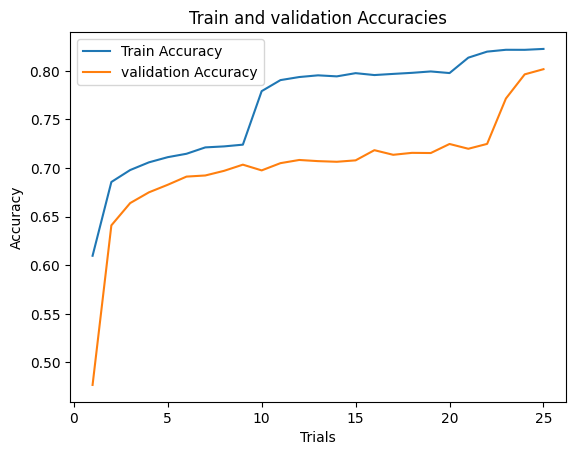

In [ ]:
# Extract train accuracies
train_trials = [t[0] for t in train_result]
train_accuracies = [t[1] for t in train_result]

# Extract test accuracies
test_trials = [t[0] for t in val_result]
test_accuracies = [t[1] for t in val_result]

# Plot accuracies
plt.plot(train_trials, train_accuracies, label='Train Accuracy')
plt.plot(test_trials, test_accuracies, label='validation Accuracy')

# Add labels and title
plt.xlabel('Trials')
plt.ylabel('Accuracy')
plt.title('Train and validation Accuracies')
plt.legend()

# Show plot
plt.show()

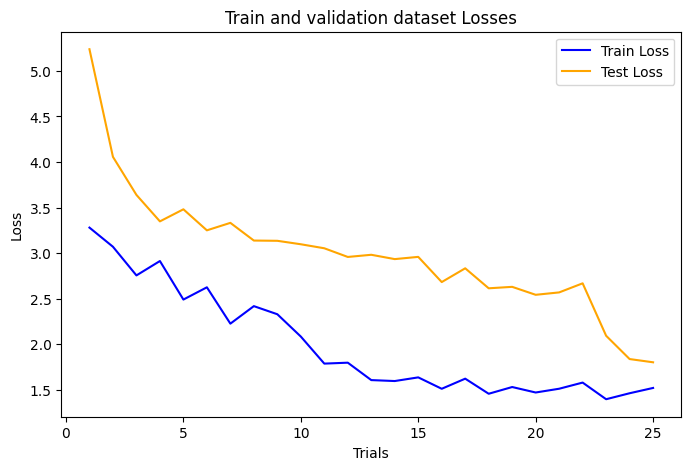

In [ ]:
# Extract train losses
train_trials = [t[0] for t in train_result]
train_losses = [t[2] for t in train_result]

# Extract test losses
test_trials = [t[0] for t in val_result]
test_losses = [t[2] for t in val_result]

# Plot losses
plt.figure(figsize=(8, 5))
plt.plot(train_trials, train_losses, label='Train Loss', color='blue')
plt.plot(test_trials, test_losses, label='Test Loss', color='orange')
plt.xlabel('Trials')
plt.ylabel('Loss')
plt.title('Train and validation dataset Losses')
plt.legend()

## Random hyperparameter search function

This function conducts a random search to explore various hyperparameters for a neural network model. It takes the number of trials to perform and the training data as inputs. The output includes a dictionary containing the best hyperparameters that resulted in the highest accuracy, along with the accuracy itself and the total time taken for training in seconds.


In [ ]:
# This function, random_search_hyperparams, implements a random search algorithm to
# explore the hyperparameter space and find the optimal combination for training a model.
def random_search_hyperparams(trials, data):
    # Start the timer
    startTime = time.time()

# It begins by defining a dictionary, hyperparams, containing ranges of values for each hyperparameter of interest.
# These include activation function, optimizer, batch normalization, regularization, dropout rate, and learning rate scheduler.
    hyperparams = {
        'activation': ['relu', 'sigmoid', 'tanh'],
        'opt': ['SGD', 'Adam', 'RMSprop'],
        'batch_norm': [True, False],
        'regularization': ['l1', 'l2', 'none'],
        'dropout': [0.0, 0.2],
        'scheduler': ['ReduceLROnPlateau', 'StepLR']
    }

    best_accuracy = 0.0
    best_hyperparams = None

  # Within the specified number of trials, the function randomly samples a set of hyperparameters from the defined ranges.
    for i in range(trials):

        # Sample a set of hyperparameters at random
        activation = random.choice(hyperparams['activation'])
        opt = random.choice(hyperparams['opt'])
        batch_norm = random.choice(hyperparams['batch_norm'])
        regularization = random.choice(hyperparams['regularization'])
        dropout = random.uniform(*hyperparams['dropout'])
        scheduler = random.choice(hyperparams['scheduler'])

# It then tests the performance of the model using the sampled hyperparameters
# by calling the hyper_params_test function, which trains the model and returns the accuracy achieved.
        result = hyper_params_test(activation, opt, batch_norm, regularization, dropout, scheduler, data)

        # Compute the accuracy of the model for the current set of hyperparameters
        accuracy = result[-1][1]

# The function compares the accuracy achieved with the best accuracy obtained so far.
# If the current set of hyperparameters yields a higher accuracy, it updates the best_accuracy and best_hyperparams variables accordingly.
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams = {
                'activation': activation,
                'opt': opt,
                'batch_norm': batch_norm,
                'regularization': regularization,
                'dropout': dropout,
                'scheduler': scheduler
            }

# After completing all trials, the function calculates the total training time by recording the start and end times.
    endTime = time.time()
    trainingTime = endTime - startTime

# Finally, it returns the best set of hyperparameters, along with the highest accuracy achieved and the total training time,
# providing valuable insights into the most effective configuration for the model.
    return best_hyperparams, best_accuracy, trainingTime

In [ ]:
best_hyperparams, best_accuracy, trainingTime = random_search_hyperparams(30, train_loader)

In [ ]:
trainingTime
best_hyperparams
best_accuracy
best_hyperparams = best_hyperparams
best_result = hyper_params_test(best_hyperparams['activation'], best_hyperparams['opt'], best_hyperparams['batch_norm'], best_hyperparams['regularization'], best_hyperparams['dropout'], best_hyperparams['scheduler'], train_loader)

In [ ]:
best_result

[(1, 0.6019725177304964, 0.7977584004402161),
 (2, 0.7719304078014184, 0.611623227596283),
 (3, 0.8078568262411348, 0.5019075870513916),
 (4, 0.8284131205673759, 0.43188726902008057),
 (5, 0.8419658687943262, 0.5186798572540283),
 (6, 0.8516400709219858, 0.40089890360832214),
 (7, 0.8596742021276595, 0.33195796608924866),
 (8, 0.8668218085106383, 0.3523034155368805),
 (9, 0.8734042553191489, 0.4306046664714813),
 (10, 0.8785460992907801, 0.38223791122436523),
 (11, 0.8828900709219858, 0.4259095788002014),
 (12, 0.8894392730496454, 0.35891738533973694),
 (13, 0.8923093971631205, 0.18770909309387207),
 (14, 0.8959330673758865, 0.32812103629112244),
 (15, 0.8998670212765958, 0.2470787763595581),
 (16, 0.9042442375886525, 0.31319916248321533),
 (17, 0.9058178191489362, 0.2262973189353943),
 (18, 0.9096409574468085, 0.2596527338027954),
 (19, 0.9138076241134752, 0.15292415022850037),
 (20, 0.9162344858156029, 0.1517050862312317),
 (21, 0.9191821808510638, 0.19481581449508667),
 (22, 0.92105

In [ ]:
test_result = hyper_params_test(best_hyperparams['activation'], best_hyperparams['opt'], best_hyperparams['batch_norm'], best_hyperparams['regularization'], best_hyperparams['dropout'], best_hyperparams['scheduler'], test_loader)
test_result

[(1, 0.34382978723404256, 1.5991809368133545),
 (2, 0.6050531914893617, 1.1914284229278564),
 (3, 0.678031914893617, 0.8939900398254395),
 (4, 0.7232978723404255, 0.6849084496498108),
 (5, 0.7572340425531915, 0.5479388236999512),
 (6, 0.7754787234042553, 0.47960925102233887),
 (7, 0.7936170212765957, 0.40191105008125305),
 (8, 0.8053191489361702, 0.369931697845459),
 (9, 0.8190425531914893, 0.30578845739364624),
 (10, 0.8301063829787234, 0.2814960181713104),
 (11, 0.8383510638297872, 0.24700140953063965),
 (12, 0.8446276595744681, 0.2529356777667999),
 (13, 0.8503723404255319, 0.23929475247859955),
 (14, 0.8565425531914893, 0.23532141745090485),
 (15, 0.8689361702127659, 0.20921124517917633),
 (16, 0.8756914893617022, 0.15837915241718292),
 (17, 0.8797340425531915, 0.17517630755901337),
 (18, 0.8865957446808511, 0.15416167676448822),
 (19, 0.8917021276595745, 0.13353075087070465),
 (20, 0.8911170212765958, 0.13225296139717102),
 (21, 0.8926595744680851, 0.13348588347434998),
 (22, 0.89

## Saving the model state dictionary

 This dictionary contains all the parameters of the model which have been adjusted during training to optimize performance.  

In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), 'mlp_model.pth')
print("Model saved successfully!")

Model saved successfully!


## Visualising training progress

### Training Accuracy Plot

The first plot displays the training accuracy over iterations during the training process. This plot shows how the model's accuracy changes over time.

### Training Loss Plot

The second plot illustrates the training loss over iterations, showing how the loss decreases as the model learns to make more accurate predictions. Lower loss values indicate better performance, as the model is minimizing the difference between predicted and actual values.


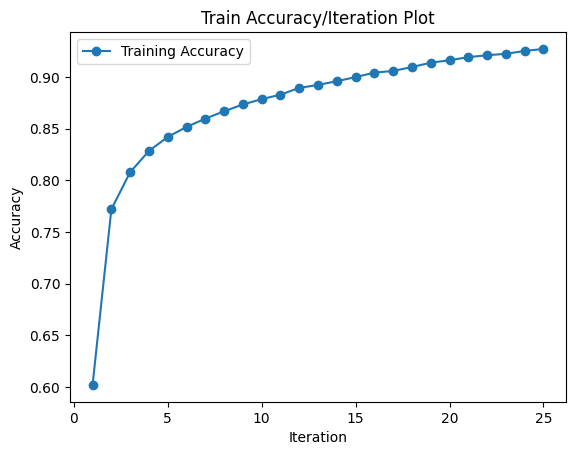

In [ ]:
# Get the first two items in each tuple and store in separate lists
train_iter = [x[0] for x in best_result]
train_accuracy = [x[1] for x in best_result]

# Plot graph for both training and validation loss
plt.plot(train_iter, train_accuracy, '-o', label='Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Train Accuracy/Iteration Plot')
plt.legend()
plt.show()

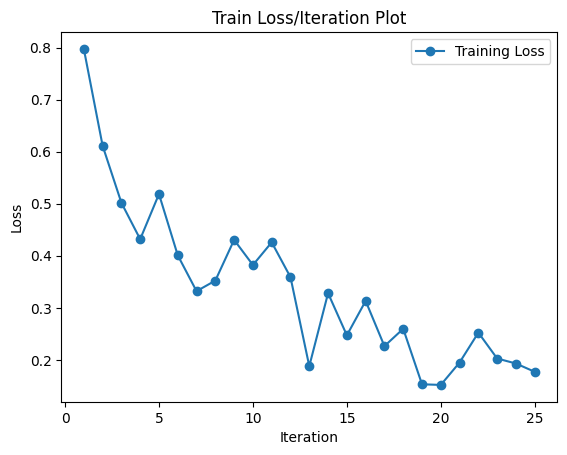

In [ ]:
# Get the first two items in each tuple and store in separate lists
train_iter = [x[0] for x in best_result]
train_loss = [x[2] for x in best_result]


# Plot graph for both training and validation loss
plt.plot(train_iter, train_loss, '-o', label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss/Iteration Plot')
plt.legend()
plt.show()

## Define the CNN model

This class defines a Convolutional Neural Network (CNN) model architecture using PyTorch. It includes convolutional layers, max-pooling layers, and fully connected layers.

### Arguments:
*   input_size: Size of the input images.
*   num_classes: Number of output classes.
*   activation: Activation function to be used in the hidden layers.
*   batch_norm: Boolean indicating whether to use batch normalization.
*   dropout: Dropout rate to be applied.
*   regularization: Regularization method to be applied.
*   regularization_lambda: Regularization weight.

### Forward Method:

The forward method defines the forward pass of the CNN model. It takes an input tensor x and passes it through the convolutional and fully connected layers to produce the output tensor.

### Get Regularization Loss Method:

The get_regularization_loss method computes the regularization loss based on the specified regularization method (l1, l2, or both). It calculates the L1, L2, or combined L1 and L2 regularization loss for all parameters of the model.

In [ ]:
# Define the Convolutional Neural Network (CNN) class
class CNN(nn.Module):
    def __init__(self, input_size, num_classes, activation, batch_norm, dropout, regularization, regularization_lambda):
        super(CNN, self).__init__()
        # The first step is to define the convolutional layers.
        # The first convolutional layer (conv1) takes a single-channel image and applies 6 different filters, each with a size of 5x5 pixels.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        # We then define a pooling layer that reduces the spatial dimensions of the image by taking the maximum value in each 2x2 region.
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # The second convolutional layer (conv2) takes the 6-channel output from the previous layer and applies 16 different filters, each with a size of 5x5 pixels.
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        # Next, we define the fully connected layers that will take the flattened output of the convolutional layers and perform the final classification.
        self.fc1 = nn.Linear(in_features=16 * 5 * 5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
        # We store the hyperparameters that will control the behavior of the network during training.
        self.activation = activation
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.regularization = regularization
        self.regularization_lambda = regularization_lambda
        # If batch normalization is enabled, we add batch normalization layers after each convolutional layer.
        # These layers will normalize the activations of the neurons in the network, which can help speed up training and improve generalization.
        if self.batch_norm:
            self.bn1 = nn.BatchNorm2d(6)
            self.bn2 = nn.BatchNorm2d(16)

    def forward(self, x):
        # The forward pass defines how an input tensor (x) is transformed into an output tensor.
        # First, we pass the input through the first convolutional layer, followed by batch normalization (if enabled), a ReLU activation function, and the pooling layer.
        out = self.conv1(x)
        if self.batch_norm:
            out = self.bn1(out)
        out = self.pool(F.relu(out))
        # We repeat this process for the second convolutional layer.
        out = self.conv2(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.pool(F.relu(out))
        # We then flatten the output tensor to prepare it for the fully connected layers.
        out = out.view(out.size(0), -1)
        # The flattened tensor is passed through the first two fully connected layers, each followed by a ReLU activation function.
        out = F.relu(self.fc1(out))
        if self.dropout:
            out = F.dropout(out, p=self.dropout)
        out = F.relu(self.fc2(out))
        # Finally, we pass through the output layer, which uses a linear activation function to produce the final class scores.
        out = self.fc3(out)
        return out

    def get_regularization_loss(self):
        # This method computes the regularization loss, which is added to the standard cross-entropy loss during training.
        # This encourages the network to have small weights, which can help prevent overfitting.
        if self.regularization == 'l1':
            return sum(torch.norm(param, p=1) for param in self.parameters())
        elif self.regularization == 'l2':
            return sum(torch.norm(param, p=2) ** 2 for param in self.parameters())
        elif self.regularization == 'both':
            l1_loss = sum(torch.norm(param, p=1) for param in self.parameters())
            l2_loss = sum(torch.norm(param, p=2) ** 2 for param in self.parameters())
            return l1_loss, l2_loss
        else:
            return 0

## CNN Model Training

*   Instantiate the CNN model with the specified hyperparameters, including input size, number of classes, activation function, batch normalization, dropout rate, regularization method, and regularization lambda.
*  Define the loss function as the CrossEntropyLoss and the optimizer as Adam with a specified learning rate.
*   Enter the training loop for the specified number of epochs.
*   Set the model to training mode.
*   Initialize variables to track training loss, correct predictions, and total samples.
*   Iterate over the training dataset batches.
*   Move the images and labels to the appropriate device (GPU or CPU).
*   Perform a forward pass through the model to obtain predictions.
*   Calculate the loss between the predictions and the actual labels.
*   Add regularization term to the loss if regularization lambda is specified.
*   Perform backward pass and optimization to update model parameters.
*   Update training loss, correct predictions, and total samples for the epoch.
*   
Compute training accuracy for the epoch.
*   Print the epoch number, average training loss, and training accuracy.
*   Adjust the learning rate using the scheduler based on the training loss.

In [ ]:
# We start by instantiating the CNN model with the specified parameters and moving it to the device
model = CNN(input_size, num_classes, activation, batch_norm, dropout, regularization, regularization_lambda).to(device)

# Next, we define the loss function, optimizer, and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

# We then enter the training loop
for epoch in range(epochs):
    # We set the model to training mode at the start of each epoch
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    # We iterate over the training dataset
    for images, labels in train_loader:
        # We move the images and labels to the device
        images, labels = images.to(device), labels.to(device)

        # We perform a forward pass through the model with the images
        outputs = model(images)
        # We calculate the loss between the model's outputs and the true labels
        loss = criterion(outputs, labels)

        # If regularization is enabled, we add the regularization loss to the total loss
        if regularization_lambda:
            reg_loss = model.get_regularization_loss()
            if isinstance(reg_loss, tuple):  # If both L1 and L2 regularization are applied
                loss += regularization_lambda * reg_loss[0] + 0.5 * regularization_lambda * reg_loss[1]
            else:
                loss += regularization_lambda * reg_loss

        # We perform a backward pass and optimize the model's parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # We add the loss of this batch to the total training loss
        train_loss += loss.item()

        # We calculate the number of correct predictions in this batch
        predicted = torch.max(outputs, 1)[1]  # Get the index of the maximum value along the second axis
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # At the end of each epoch, we compute the training accuracy
    train_accuracy = correct / total

    # We print the loss and accuracy for this epoch
    # print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}, Accuracy: {100 * train_accuracy:.2f}%")

    # We adjust the learning rate based on the training loss
    scheduler.step(train_loss)

# Finally, we print the model's accuracy without L1/L2 regularization and with L1 or L2 regularization
# Accuracy without L1/L2 ~ 71%
# Accuracy with L2 OR L1 is more or less the same

## Function to train CNN model with hyper-parameters

The following code defines a function hyperparam_test to perform hyperparameter tuning for a Convolutional Neural Network (CNN) model. This function takes various hyperparameters such as activation function, optimizer, batch normalization, regularization, dropout, learning rate scheduler, data, and regularization weight as input.

The CNN model is initialized and moved to the appropriate device. The loss function, optimizer, and learning rate scheduler are defined based on the input hyperparameters. The training loop iterates over the dataset for a specified number of epochs, computing loss and accuracy metrics, and adjusting the learning rate using the scheduler.

The function returns a list of tuples containing the epoch index, accuracy, and loss for each epoch. This information can be used to analyze the performance of different hyperparameter configurations and select the best set of hyperparameters for the CNN model.

In [ ]:
def hyperparam_test(activation, optimizer_name, batch_norm, regularization, dropout, lr_scheduler_name, data, regularization_lambda):
    # We start by initializing the CNN model. The model is defined with the specified parameters,
    # which include the activation function, whether to use batch normalization, dropout rate,
    # regularization type, and regularization weight. The model is then moved to the device for computation.
    model = CNN(input_size, num_classes, activation, batch_norm, dropout, regularization, regularization_lambda).to(device)

    # Next, we define the loss function. In this case, we're using Cross Entropy Loss,
    # which is commonly used for classification problems.
    criterion = nn.CrossEntropyLoss()

    # We define dictionaries for the optimizers and learning rate schedulers.
    # This allows us to easily select the optimizer and scheduler based on the provided names.
    optimizers = {
        'Adam': optim.Adam,
        'SGD': optim.SGD,
        'RMSprop': optim.RMSprop
    }
    schedulers = {
        'ReduceLROnPlateau': optim.lr_scheduler.ReduceLROnPlateau,
        'StepLR': optim.lr_scheduler.StepLR
    }

    # We initialize the optimizer and learning rate scheduler using the dictionaries.
    # This allows us to easily change the optimizer and scheduler by just changing the name.
    optimizer = optimizers[optimizer_name](model.parameters())  # Initialize optimizer with model parameters
    if lr_scheduler_name == 'StepLR':
        # Add step_size argument for StepLR scheduler
        scheduler = schedulers[lr_scheduler_name](optimizer, step_size=1, verbose=True)
    else:
        scheduler = schedulers[lr_scheduler_name](optimizer, verbose=True)

    # We create lists to store the accuracy and loss values for each epoch.
    # These will be used for analysis and visualization of the training process.
    accuracy = []
    losses = []
    iter = []

    # We start timing the training process. This allows us to see how long the training takes.
    startTime = time.time()

    # We enter the training loop. This is where the actual learning happens.
    for epoch in range(epochs):
        # At the start of each epoch, we ensure the model is in training mode.
        model.train()
        correct = 0
        total = 0

        # We iterate over the training data. For each batch of images and labels:
        for images, labels in data:
            # We move the images and labels to the device. This is necessary because the computations are done on the device.
            images, labels = images.to(device), labels.to(device)

            # We perform a forward pass through the model with the images, getting the model's outputs.
            outputs = model(images)
            # We calculate the loss between the model's outputs and the true labels.
            loss = criterion(outputs, labels)

            # If regularization is enabled, we add the regularization loss to the total loss.
            if regularization == 'l1':
                loss += regularization_lambda * sum(torch.norm(param, p=1) for param in model.parameters())
            elif regularization == 'l2':
                loss += regularization_lambda * sum(torch.norm(param, p=2)**2 for param in model.parameters())
            elif regularization == 'both':
                loss += regularization_lambda * sum(torch.norm(param, p=1) for param in model.parameters())
                loss += regularization_lambda * sum(torch.norm(param, p=2)**2 for param in model.parameters())
            else:
              pass

            # We perform a backward pass and optimize the model's parameters.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # We calculate the number of correct predictions in this batch and add it to the total number of correct predictions.
            predicted = torch.max(outputs, 1)[1]
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # At the end of each epoch, we update the learning rate based on the total loss.
        scheduler.step(loss)

        # We record the accuracy and loss for this epoch. These will be returned by the function.
        epoch_accuracy = correct / total
        accuracy.append(epoch_accuracy)
        losses.append(loss.item())
        iter.append(epoch + 1)

    # We stop timing the training process and calculate the total training time.
    endTime = time.time()
    trainingTime = endTime - startTime

    # Finally, we return a list of tuples containing the epoch index, accuracy, and loss for each epoch.
    return list(zip(iter, accuracy, losses))


In [ ]:
activation = 'relu'
optimizer = 'Adam'
batch_norm = True
regularization = 'l1'
dropout = 0.3
lr_scheduler = 'ReduceLROnPlateau'
regularization_lambda = 0.001
train_result = hyperparam_test(activation, optimizer, batch_norm, regularization, dropout, lr_scheduler, train_loader, regularization_lambda)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [ ]:
activation = 'relu'
optimizer = 'Adam'
batch_norm = True
regularization = 'l1'
dropout = 0.3
lr_scheduler = 'ReduceLROnPlateau'
regularization_weight = 0.001
val_result = hyperparam_test(activation, optimizer, batch_norm, regularization, dropout, lr_scheduler, val_loader, regularization_weight)

In [ ]:
train_result

[(1, 0.5272606382978723, 1.763338565826416),
 (2, 0.7196032801418439, 1.5869839191436768),
 (3, 0.7499445921985816, 1.436970591545105),
 (4, 0.7660128546099291, 1.4435765743255615),
 (5, 0.776030585106383, 1.5042446851730347),
 (6, 0.7829122340425532, 1.1991345882415771),
 (7, 0.7871564716312057, 1.24257230758667),
 (8, 0.7902149822695036, 1.3225219249725342),
 (9, 0.7936724290780142, 1.308595895767212),
 (10, 0.7954676418439717, 1.1877659559249878),
 (11, 0.7985926418439716, 1.1630580425262451),
 (12, 0.800321365248227, 1.1765869855880737),
 (13, 0.7992132092198582, 1.221559762954712),
 (14, 0.8012189716312057, 1.1878327131271362),
 (15, 0.8047539893617022, 1.0846319198608398),
 (16, 0.8033577127659575, 1.1043777465820312),
 (17, 0.8040447695035461, 1.0183426141738892),
 (18, 0.8051196808510638, 1.058778166770935),
 (19, 0.8059064716312057, 1.144888162612915),
 (20, 0.8055851063829788, 1.3117492198944092),
 (21, 0.8088984929078015, 0.9841309785842896),
 (22, 0.8098625886524823, 1.2080

In [ ]:
val_result

[(1, 0.23515070921985815, 3.1484994888305664),
 (2, 0.5858156028368794, 2.483450412750244),
 (3, 0.6651152482269503, 2.242194652557373),
 (4, 0.6945921985815603, 2.0429651737213135),
 (5, 0.7124113475177305, 2.0192248821258545),
 (6, 0.7235815602836879, 1.9475538730621338),
 (7, 0.7342198581560284, 1.6686387062072754),
 (8, 0.7410017730496454, 1.6188185214996338),
 (9, 0.7474290780141843, 1.6851215362548828),
 (10, 0.7489361702127659, 1.5957973003387451),
 (11, 0.7552748226950354, 1.5834097862243652),
 (12, 0.7606382978723404, 1.5155951976776123),
 (13, 0.7629432624113475, 1.4716153144836426),
 (14, 0.7628102836879432, 1.5614596605300903),
 (15, 0.7691489361702127, 1.4799871444702148),
 (16, 0.7726507092198581, 1.518160343170166),
 (17, 0.7750443262411347, 1.4670648574829102),
 (18, 0.774645390070922, 1.4347288608551025),
 (19, 0.7777039007092199, 1.3508310317993164),
 (20, 0.7780141843971631, 1.5018110275268555),
 (21, 0.7787677304964539, 1.4306446313858032),
 (22, 0.7839982269503546,

## Plot Training and Validation Accuracies/Losses

This code extracts training and validation accuracies/losses from the results of different hyperparameter configurations and plots them to visualise the training progress.

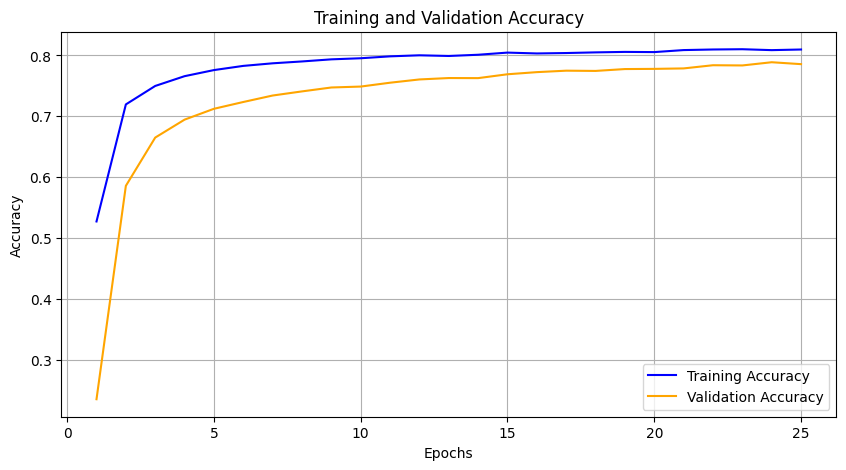

In [ ]:
# Get the first two items in each tuple and store in separate lists
train_iter = [x[0] for x in train_result]
train_accuracy = [x[1] for x in train_result]
val_iter = [x[0] for x in val_result]
val_accuracy = [x[1] for x in val_result]

# Plotting the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_iter, train_accuracy, label='Training Accuracy', color='blue')
plt.plot(val_iter, val_accuracy, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


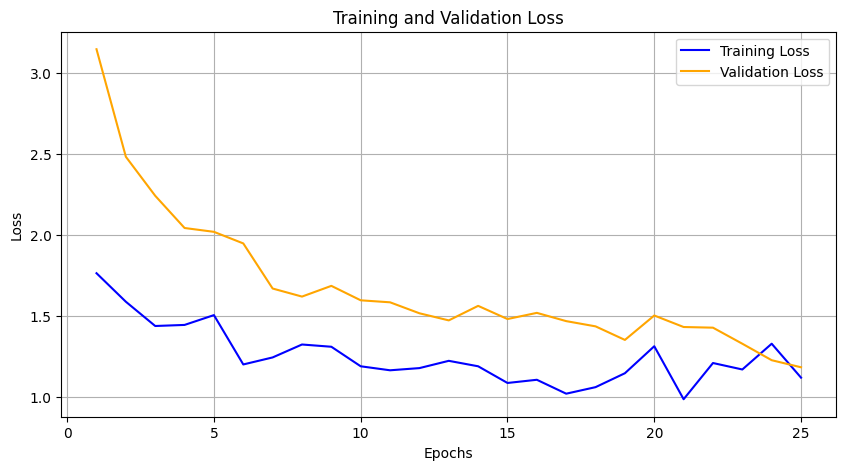

In [ ]:
# Get the first two items in each tuple and store in separate lists
train_iter = [x[0] for x in train_result]
train_loss = [x[2] for x in train_result]
val_iter = [x[0] for x in val_result]
val_loss = [x[2] for x in val_result]

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_iter, train_loss, label='Training Loss', color='blue')
plt.plot(val_iter, val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Visualising Convolutional Layer Weights

This code retrieves the weights of the first convolutional layer from a neural network model and visualises them as images using matplotlib.

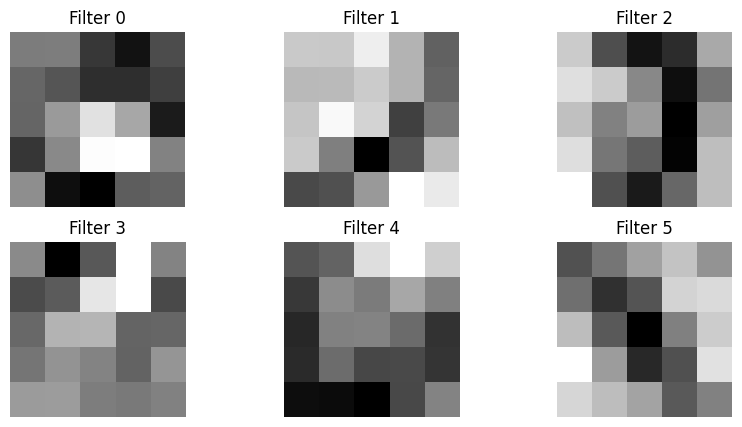

In [ ]:
# Get the weights of the first convolutional layer
conv1_weights = model.conv1.weight.data

# Visualise the weights
plt.figure(figsize=(10, 5))
for i in range(conv1_weights.shape[0]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(conv1_weights[i, 0].cpu().detach().numpy(), cmap='gray')
    plt.title(f'Filter {i}')
    plt.axis('off')
plt.show()

## Random hyperparameter search function

This function conducts a random search to explore various hyperparameters for a neural network model. It takes the number of trials to perform and the training data as inputs. The output includes a dictionary containing the best hyperparameters that resulted in the highest accuracy, along with the accuracy itself and the total time taken for training in seconds.


In [ ]:
def random_search(iterations, data):
    # Firstly, start timing the random search process
    startTime = time.time()

    # Define the range of values for each hyperparameter
    hyperparams = {
        'activation': ['relu', 'sigmoid', 'tanh'],
        'opt': ['SGD', 'Adam', 'RMSprop'],
        'batch_norm': [True, False],
        'regularization': ['l1', 'l2', 'none'],
        'regularization_weight': [0.01, 0.001, 0.0001],
        'dropout': [0.0, 0.2],
        'scheduler': ['ReduceLROnPlateau', 'StepLR']
    }

    # Initialize variables to track the best hyperparameters and accuracy found so far
    best_accuracy = 0.0
    best_hyperparams = None
    trial_accuracies = []

    # Then, iterate over the specified number of random search iterations
    for i in range(iterations):
        # Sample a set of hyperparameters at random from the defined ranges
        activation = random.choice(hyperparams['activation'])
        opt = random.choice(hyperparams['opt'])
        batch_norm = random.choice(hyperparams['batch_norm'])
        regularization = random.choice(hyperparams['regularization'])
        regularization_weight = random.choice(hyperparams['regularization_weight'])
        dropout = random.uniform(*hyperparams['dropout'])
        scheduler = random.choice(hyperparams['scheduler'])

        # Test the current set of hyperparameters
        result = hyperparam_test(activation, opt, batch_norm, regularization, dropout, scheduler, data, regularization_weight)

        # Compute the accuracy of the model for the current set of hyperparameters
        accuracy = result[-1][1]
        trial_accuracies.append(accuracy)

        # Check if the current set of hyperparameters has produced the best accuracy so far
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_hyperparams = {
                'activation': activation,
                'opt': opt,
                'batch_norm': batch_norm,
                'regularization': regularization,
                'regularization_weight': regularization_weight,
                'dropout': dropout,
                'scheduler': scheduler
            }

    # Finally, end timing the random search process
    endTime = time.time()
    trainingTime = endTime - startTime

    # Return the best hyperparameters, best accuracy, trial accuracies, and total training time
    return best_hyperparams, best_accuracy, trial_accuracies, trainingTime

# Perform random search with 30 iterations on the provided training data
best_hyperparams, best_accuracy, trial_accuracies, trainingTime = random_search(30, train_loader)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [ ]:
trainingTime

1400.6523110866547

In [ ]:
best_hyperparams

{'activation': 'tanh',
 'opt': 'Adam',
 'batch_norm': True,
 'regularization': 'l2',
 'regularization_weight': 0.0001,
 'dropout': 0.12339846275529472,
 'scheduler': 'ReduceLROnPlateau'}

In [ ]:
best_accuracy

0.9045212765957447

In [ ]:
trial_accuracies

[0.822019060283688,
 0.9045212765957447,
 0.023769946808510637,
 0.8247562056737588,
 0.02160904255319149,
 0.8877437943262412,
 0.021099290780141843,
 0.8954676418439717,
 0.8691600177304964,
 0.8229388297872341,
 0.5092309397163121,
 0.022650709219858157,
 0.023515070921985817,
 0.020257092198581562,
 0.7369570035460993,
 0.02127659574468085,
 0.021365248226950354,
 0.9034352836879432,
 0.0414561170212766,
 0.8681959219858156,
 0.9013630319148936,
 0.8884862588652482,
 0.021143617021276595,
 0.8332557624113475,
 0.0212322695035461,
 0.02165336879432624,
 0.46822916666666664,
 0.01695478723404255,
 0.8954787234042553,
 0.8639295212765957]

In [ ]:
best_hyperparams = best_hyperparams
test_result = hyperparam_test(best_hyperparams['activation'], best_hyperparams['opt'], best_hyperparams['batch_norm'], best_hyperparams['regularization'], best_hyperparams['dropout'], best_hyperparams['scheduler'], test_loader, best_hyperparams['regularization_weight'])

In [ ]:
test_result

[(1, 0.3216489361702128, 1.5305390357971191),
 (2, 0.6612234042553191, 0.9370660185813904),
 (3, 0.7407446808510638, 0.7532484531402588),
 (4, 0.7704787234042553, 0.6126859784126282),
 (5, 0.7905851063829787, 0.5476211905479431),
 (6, 0.806968085106383, 0.4519623816013336),
 (7, 0.8193617021276596, 0.4637033939361572),
 (8, 0.8262234042553191, 0.392875611782074),
 (9, 0.8331382978723404, 0.35640066862106323),
 (10, 0.841063829787234, 0.3345462381839752),
 (11, 0.8443617021276596, 0.3233804702758789),
 (12, 0.8493085106382978, 0.3158637285232544),
 (13, 0.8541489361702128, 0.2858225703239441),
 (14, 0.8599468085106383, 0.27354392409324646),
 (15, 0.8604787234042554, 0.2751879394054413),
 (16, 0.8681914893617021, 0.24596963822841644),
 (17, 0.870531914893617, 0.23978523910045624),
 (18, 0.8725, 0.23465697467327118),
 (19, 0.877127659574468, 0.21976090967655182),
 (20, 0.8763829787234042, 0.23534563183784485),
 (21, 0.8768617021276596, 0.21851877868175507),
 (22, 0.8819148936170212, 0.225

In [ ]:
best_hyperparams = best_hyperparams
best_result = hyperparam_test(best_hyperparams['activation'], best_hyperparams['opt'], best_hyperparams['batch_norm'], best_hyperparams['regularization'], best_hyperparams['dropout'], best_hyperparams['scheduler'], train_loader, best_hyperparams['regularization_weight'])

In [ ]:
best_result

[(1, 0.6600177304964538, 0.5059678554534912),
 (2, 0.8164561170212766, 0.5468268394470215),
 (3, 0.8371564716312057, 0.590756893157959),
 (4, 0.8476396276595745, 0.5123711228370667),
 (5, 0.8546320921985816, 0.4426637589931488),
 (6, 0.8604499113475177, 0.3814893662929535),
 (7, 0.8645722517730496, 0.5028048753738403),
 (8, 0.8684618794326241, 0.32779890298843384),
 (9, 0.8706227836879432, 0.35536929965019226),
 (10, 0.8750221631205674, 0.366394579410553),
 (11, 0.87521054964539, 0.5525273680686951),
 (12, 0.8780695921985816, 0.41231784224510193),
 (13, 0.8797096631205674, 0.4086093604564667),
 (14, 0.8818484042553192, 0.3409760892391205),
 (15, 0.8824800531914894, 0.27744853496551514),
 (16, 0.8840425531914894, 0.5206875205039978),
 (17, 0.8848182624113475, 0.4380730986595154),
 (18, 0.8855718085106383, 0.24351222813129425),
 (19, 0.8869015957446809, 0.34258630871772766),
 (20, 0.8892176418439717, 0.2339714616537094),
 (21, 0.8911679964539007, 0.31539735198020935),
 (22, 0.89128989361

## Saving the model state dictionary

 This dictionary contains all the parameters of the model which have been adjusted during training to optimize performance.  

In [ ]:
# Save the model state dictionary
torch.save(model.state_dict(), 'cnn_model.pth')
print("Model saved successfully!")

Model saved successfully!


## Visualising training progress

### Training Accuracy Plot

The first plot displays the training accuracy over iterations during the training process. This plot shows how the model's accuracy changes over time.

### Training Loss Plot

The second plot illustrates the training loss over iterations, showing how the loss decreases as the model learns to make more accurate predictions. Lower loss values indicate better performance, as the model is minimizing the difference between predicted and actual values.


In [ ]:
train_epochs = [item[0] for item in best_result]
train_accuracies = [item[1] for item in best_result]
train_losses = [item[2] for item in best_result]


In [ ]:
test_epochs = [item[0] for item in test_result]
test_accuracies = [item[1] for item in test_result]
test_losses = [item[2] for item in test_result]


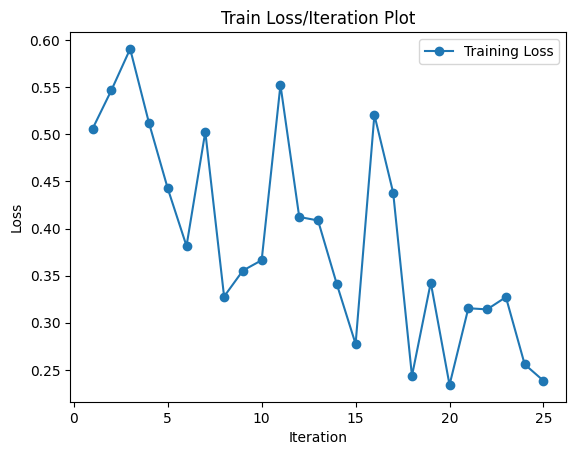

In [ ]:
# Get the first two items in each tuple and store in separate lists
train_iter = [x[0] for x in best_result]
train_loss = [x[2] for x in best_result]


# Plot elbow graph for both training and validation loss
plt.plot(train_iter, train_loss, '-o', label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Train Loss/Iteration Plot')
plt.legend()
plt.show()

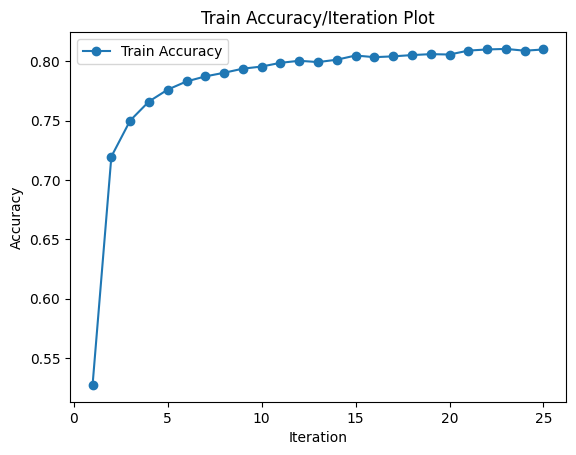

In [ ]:
# Get the first two items in each tuple and store in separate lists
test_iter = [x[0] for x in best_result]
test_accuracy = [x[1] for x in best_result]

# Plot graph for both training and validation loss
plt.plot(train_iter, train_accuracy, '-o', label='Train Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Train Accuracy/Iteration Plot')
plt.legend()
plt.show()

## Evaluating the Trained MLP Model

This code snippet loads trained and saved MLP model, evaluates its performance on test data, prints the test accuracy, generates a classification report, and displays the top 6 predictions along with their true labels with corresponding images.

In [ ]:
# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mlp_model = MLP(input_size, hidden_size, num_classes, activation, batch_norm, dropout, regularization).to(device)
mlp_model.load_state_dict(torch.load('mlp_model.pth'))
mlp_model.eval()

MLP(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=47, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l1): L1Loss()
  (l2): MSELoss()
)

In [ ]:
# Run test data through the model
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.to('cpu')
        labels=labels.to('cpu')
        y_true.extend(labels)
        y_pred.extend(predicted)

print('Test Accuracy: {}%'.format(100 * correct / total))

Test Accuracy: 85.15957446808511%


In [ ]:
# Move the tensors from GPU to CPU
y_true_cpu = [label.cpu().numpy() for label in y_true]
y_pred_cpu = [prediction.cpu().numpy() for prediction in y_pred]

# Generate a classification report
print(classification_report(y_true_cpu, y_pred_cpu))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67       400
           1       0.50      0.83      0.62       400
           2       0.85      0.90      0.87       400
           3       0.96      0.97      0.97       400
           4       0.85      0.92      0.88       400
           5       0.92      0.82      0.87       400
           6       0.93      0.86      0.89       400
           7       0.94      0.98      0.96       400
           8       0.90      0.89      0.89       400
           9       0.61      0.86      0.72       400
          10       0.92      0.97      0.95       400
          11       0.95      0.91      0.93       400
          12       0.90      0.97      0.94       400
          13       0.82      0.93      0.87       400
          14       0.97      0.93      0.95       400
          15       0.74      0.41      0.52       400
          16       0.93      0.90      0.91       400
          17       0.96    

Predicted: 41, True Label: 41


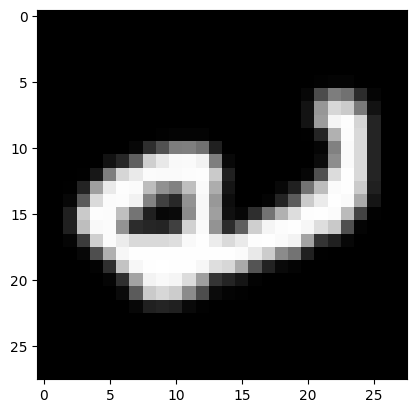

Predicted: 39, True Label: 39


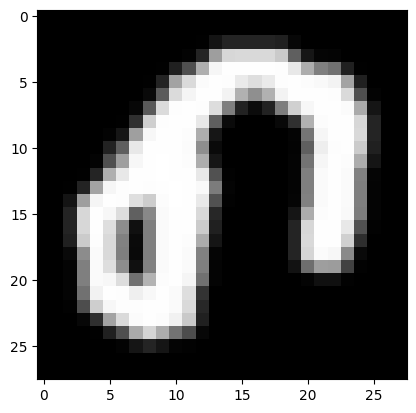

Predicted: 9, True Label: 9


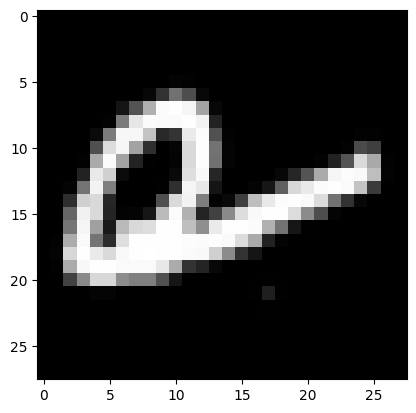

Predicted: 26, True Label: 26


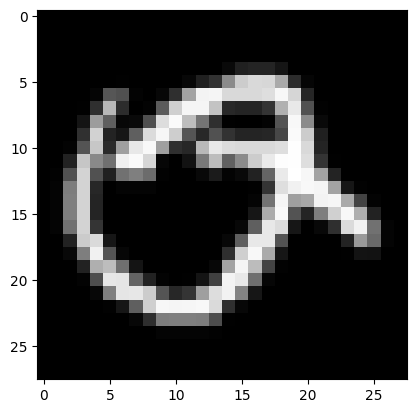

Predicted: 9, True Label: 44


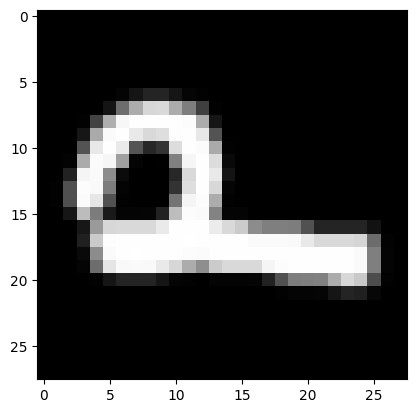

Predicted: 33, True Label: 33


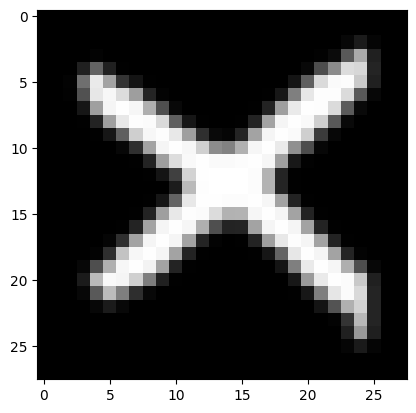

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Print the top 6 predictions with true labels
        for i in range(min(6, len(images))):
            print(f"Predicted: {predicted[i]}, True Label: {labels[i]}")

            # Plot the image
            image_index = i
            image = images[image_index].cpu().numpy()
            pixels = image.reshape((28, 28))

            plt.imshow(pixels, cmap='gray')
            plt.show()
        break

## Evaluating the Trained CNN Model

This code snippet loads the trained and saved CNN model, evaluates its performance on test data, prints the test accuracy, generates a classification report, and displays the top 6 predictions along with their true labels with corresponding images.

In [ ]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model = CNN(input_size, num_classes, activation, batch_norm, dropout, regularization, regularization_weight)
cnn_model = cnn_model.to(device)
cnn_model.load_state_dict(torch.load('cnn_model.pth', map_location=device))

# Set the model to evaluation mode
cnn_model.eval()


CNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=47, bias=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [ ]:
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.to(device)
        labels=labels.to(device)
        y_true.extend(labels)
        y_pred.extend(predicted)

print('Test Accuracy: {}%'.format(100 * correct / total))
print(predicted)
print(correct)

Test Accuracy: 84.05851063829788%
tensor([28, 26, 44, 19, 30, 13, 16, 16, 40, 42, 10, 12, 32, 30, 34, 40, 45, 14,
         0, 30, 31, 12, 33, 35, 13,  5, 19, 31, 11, 26, 30,  0, 23, 34, 39, 22,
        14, 32, 11, 36, 42,  9, 42, 17, 32, 16, 41, 10, 18,  3,  4, 24, 42, 12,
        11, 17, 26, 12, 21, 43, 20,  4, 10, 39, 16, 30, 16, 42, 41, 32, 12, 23,
        21, 20, 37, 13,  5, 36, 13, 37, 40, 29,  6,  6, 12, 45, 28,  0, 29,  0,
        22, 22, 31, 31, 20,  8, 26, 27, 33, 40, 38,  0, 33, 23, 29, 37, 24, 45,
        15, 21, 26, 33], device='cuda:0')
15803


Predicted: 41, True Label: 41


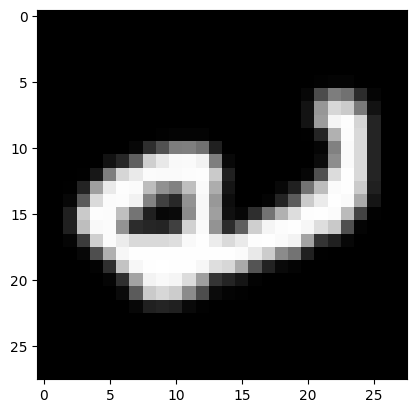

Predicted: 39, True Label: 39


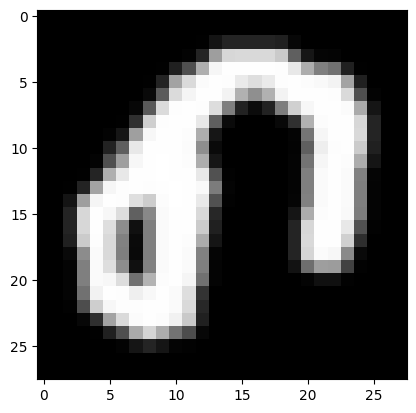

Predicted: 9, True Label: 9


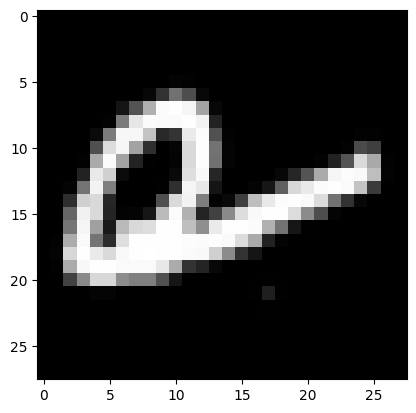

Predicted: 26, True Label: 26


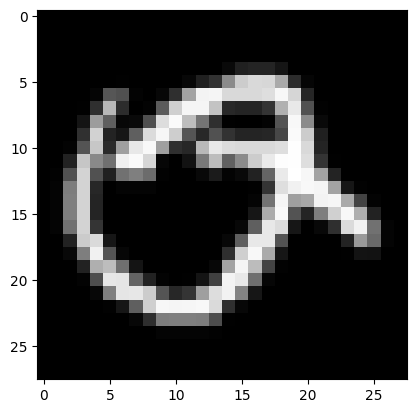

Predicted: 9, True Label: 44


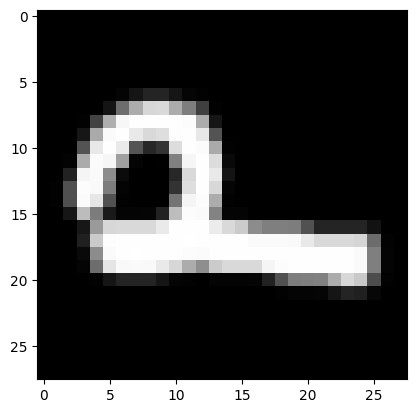

Predicted: 33, True Label: 33


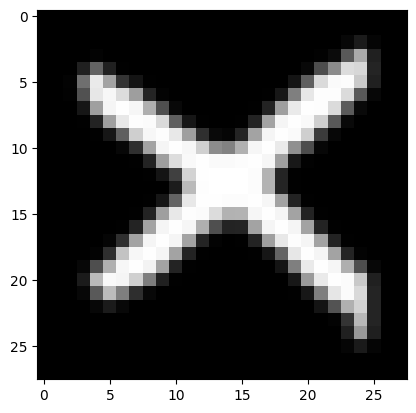

In [ ]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Print the top 6 predictions with true labels
        for i in range(min(6, len(images))):
            print(f"Predicted: {predicted[i]}, True Label: {labels[i]}")

            # Plot the image
            image_index = i
            image = images[image_index].cpu().numpy()
            pixels = image.reshape((28, 28))

            plt.imshow(pixels, cmap='gray')
            plt.show()
        break

In [ ]:
# Move the tensors from GPU to CPU
y_true_cpu = [label.cpu().numpy() for label in y_true]
y_pred_cpu = [prediction.cpu().numpy() for prediction in y_pred]

# Generate a classification report
print(classification_report(y_true_cpu, y_pred_cpu))


              precision    recall  f1-score   support

           0       0.61      0.74      0.67       400
           1       0.51      0.75      0.60       400
           2       0.84      0.88      0.86       400
           3       0.97      0.95      0.96       400
           4       0.85      0.93      0.89       400
           5       0.91      0.80      0.85       400
           6       0.90      0.87      0.88       400
           7       0.95      0.97      0.96       400
           8       0.88      0.89      0.88       400
           9       0.62      0.84      0.71       400
          10       0.92      0.94      0.93       400
          11       0.94      0.89      0.91       400
          12       0.86      0.96      0.91       400
          13       0.80      0.93      0.86       400
          14       0.95      0.92      0.93       400
          15       0.71      0.41      0.52       400
          16       0.89      0.87      0.88       400
          17       0.96    

## Visualising MLP Model Performance with Confusion Matrix

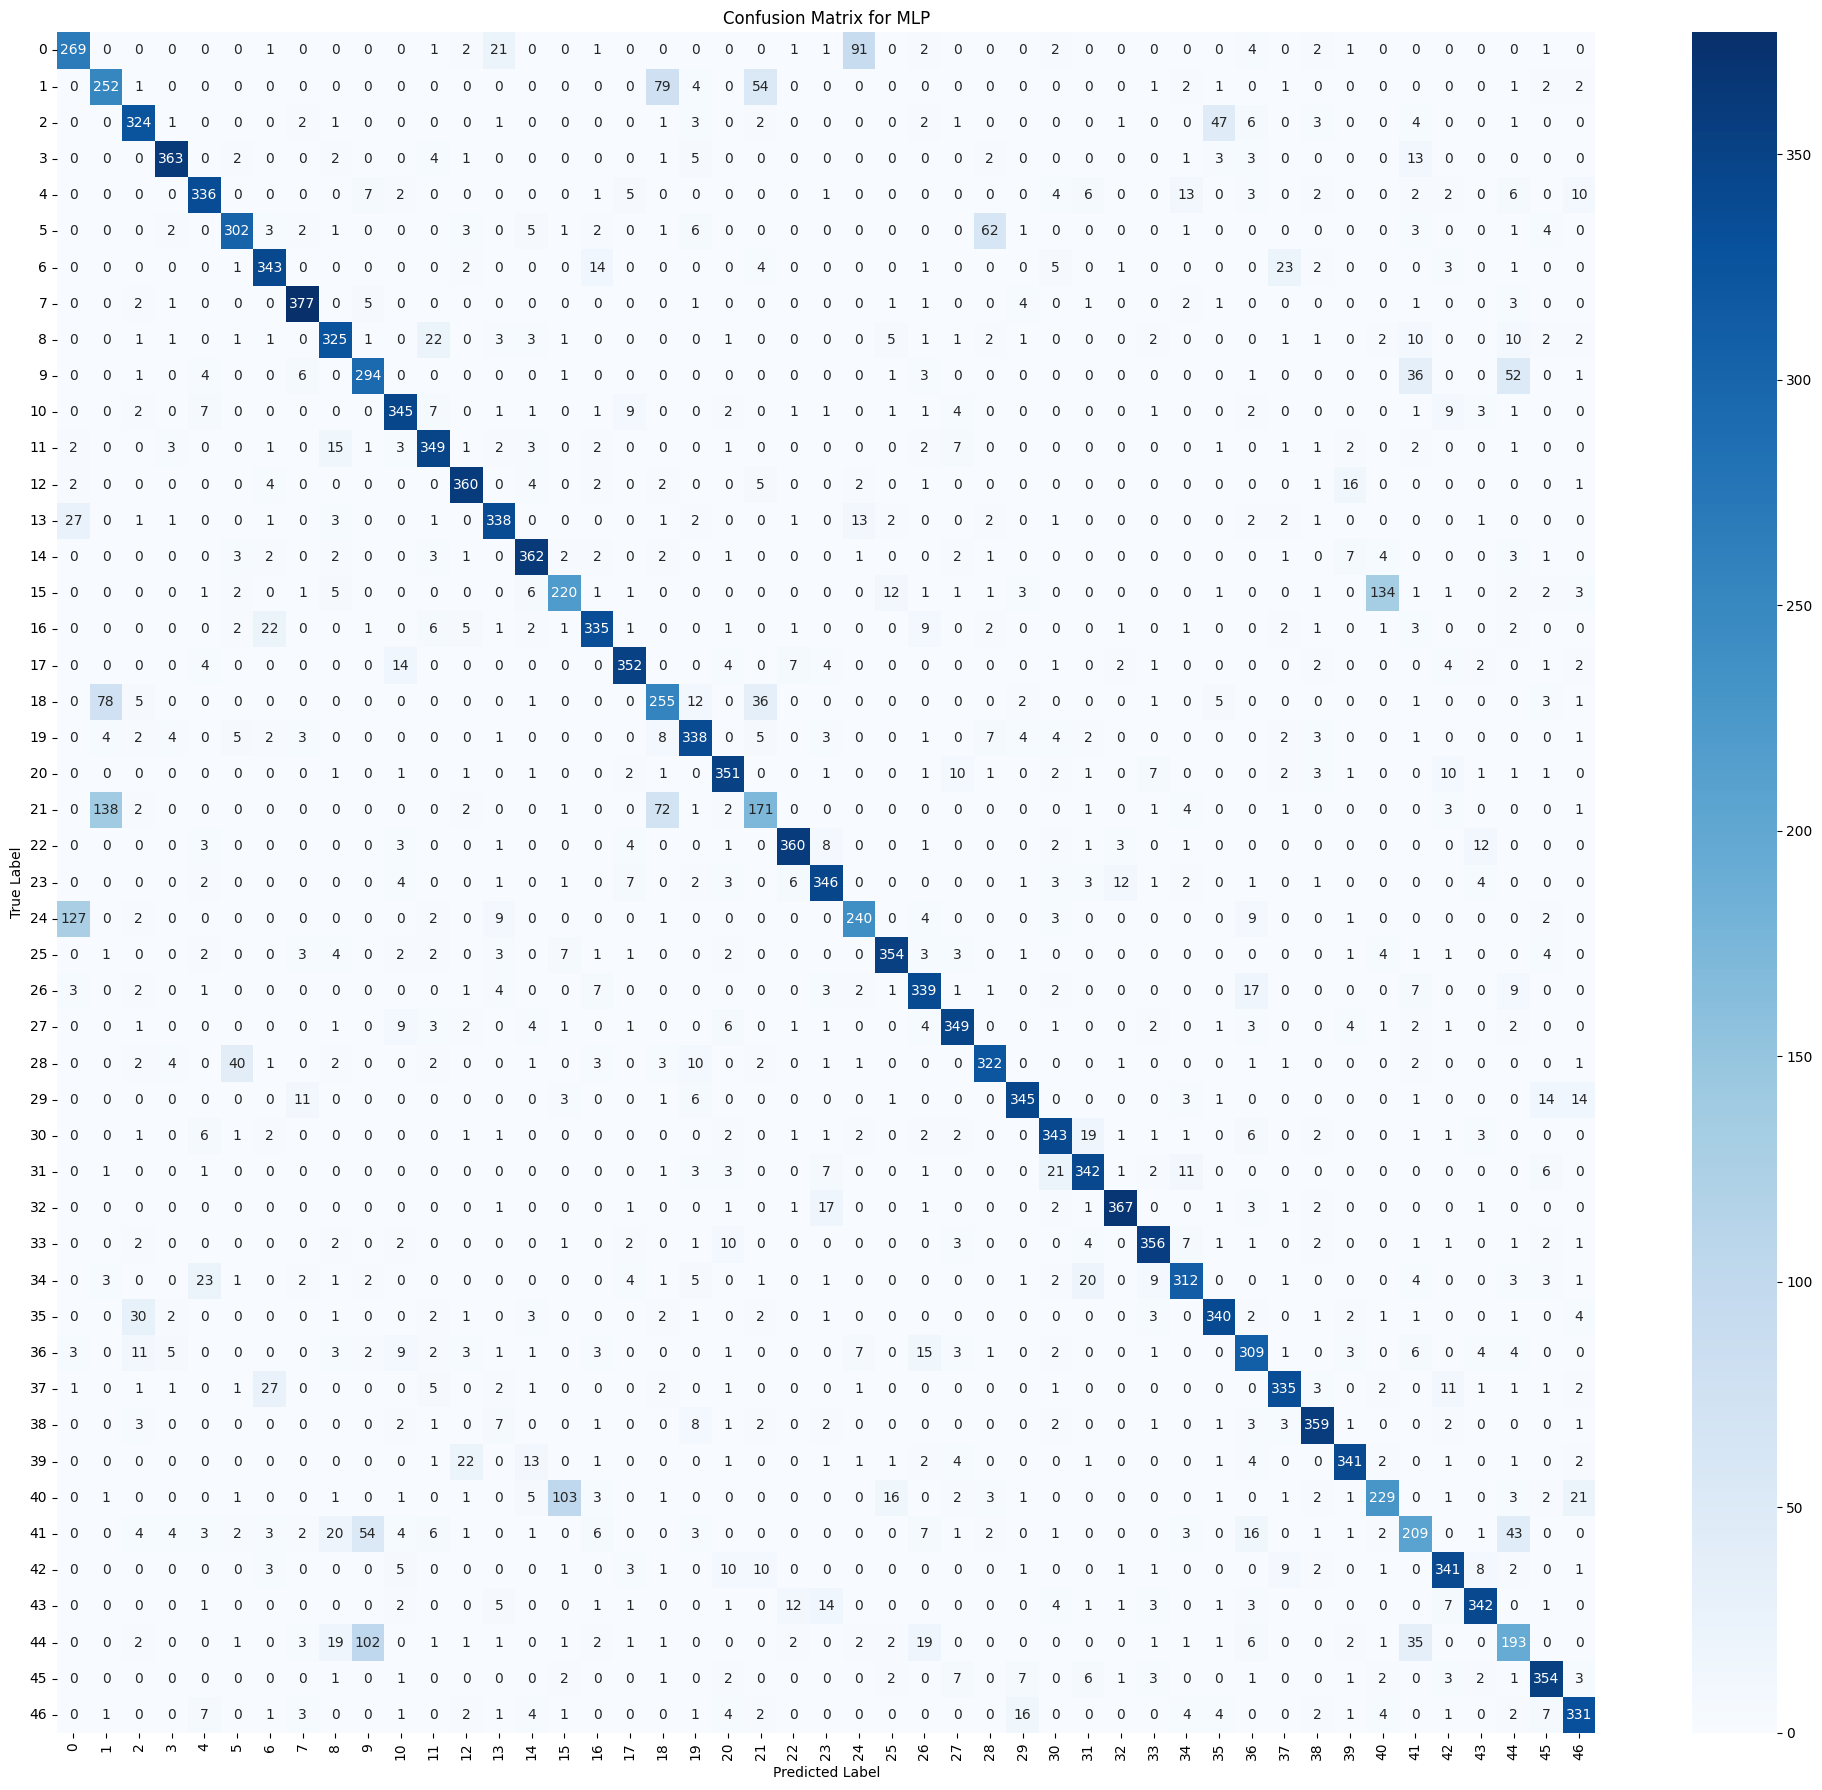

In [ ]:
# Get true labels
true_labels = []
for _, labels in test_loader:
    true_labels += labels.tolist()

# Make predictions using MLP model
mlp_predictions = []
mlp_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = mlp_model(images)
        _, predicted = torch.max(outputs.data, 1)
        mlp_predictions += predicted.tolist()

# Create confusion matrix
mlp_cm = confusion_matrix(true_labels, mlp_predictions)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Visualising CNN Model Performance with Confusion Matrix

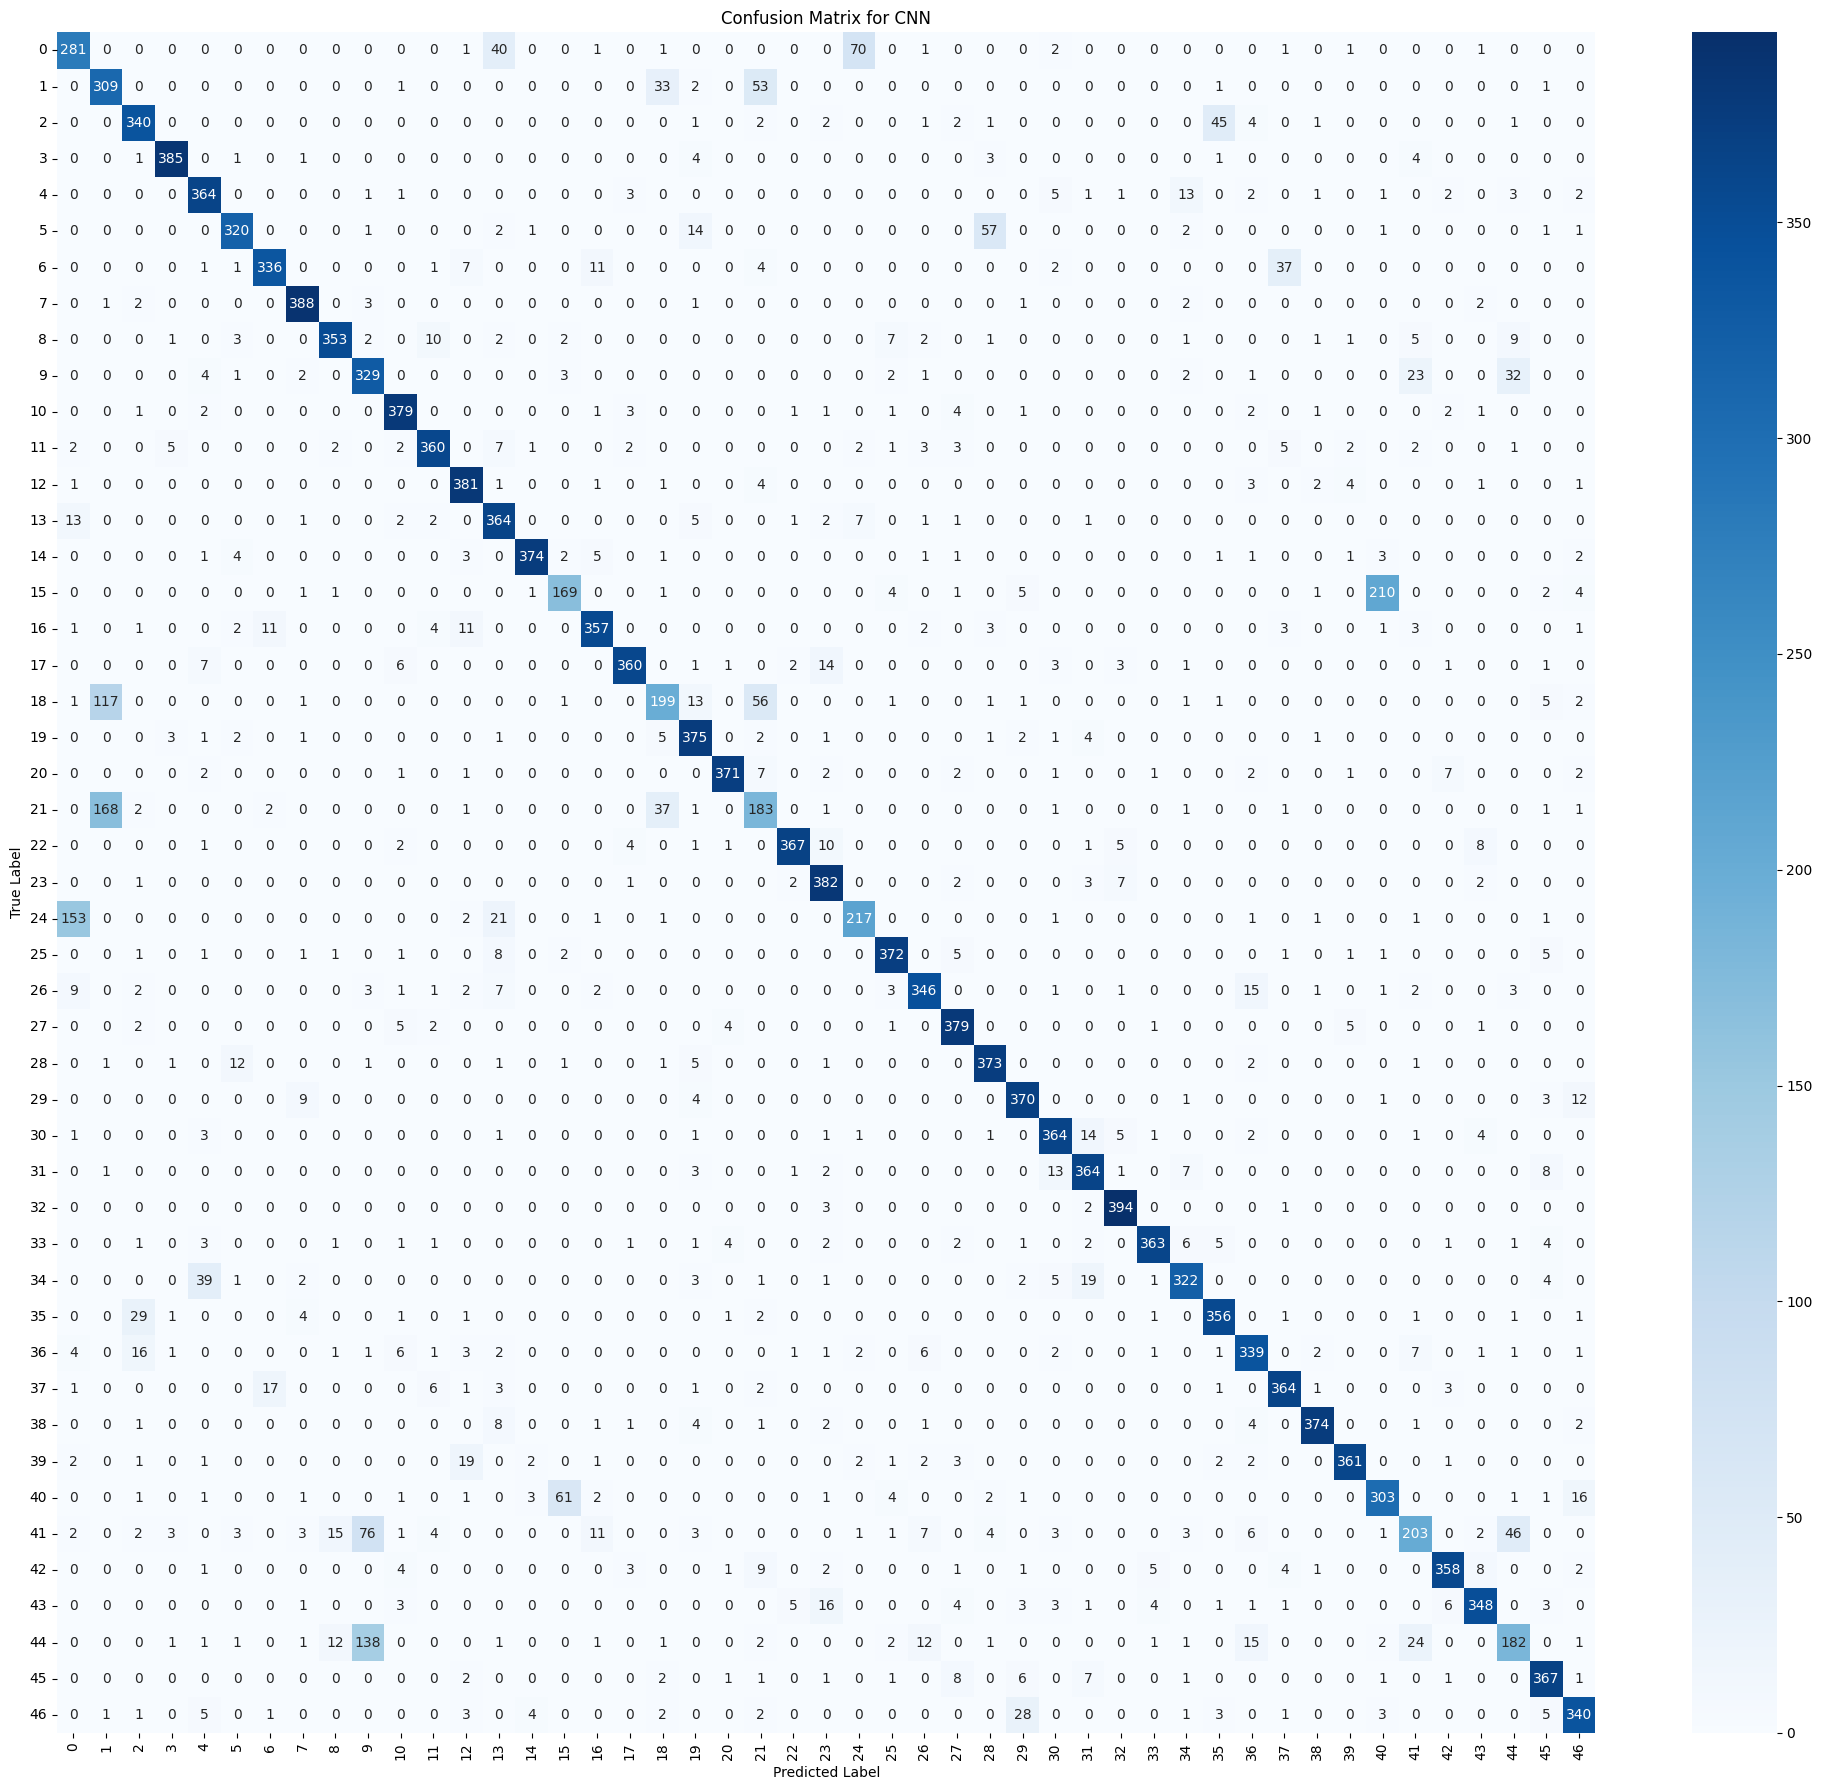

In [ ]:
# Make predictions using CNN model
cnn_predictions = []
cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        _, predicted = torch.max(outputs.data, 1)
        cnn_predictions += predicted.tolist()

# Create confusion matrix
cnn_cm = confusion_matrix(true_labels, cnn_predictions)

# Plot confusion matrix
plt.figure(figsize=(20, 18))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for CNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()